In [116]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pickle


In [117]:
# Определим названия папки для датасетов.
data_folder = 'data'

# Проверим, существует ли папка. Если нет, то создадим ее. 
if not os.path.exists('data'):
    os.mkdir('data')

In [118]:
# Устанавливаем начальное значение счетчика для нумерации файлов
# датасетов и изменения пвраметра шума.
counter = 1

In [119]:
# Определяем параметры для создания датасета.
# Значения предиктора x:
x_min = 0
x_max = 200

# Значения шума:
noise_list = [200, 190, 210, 800] 
# Последнее значение - для зашумленных данных. 

# Параметры для расчета целевой переменной y:
b_0 = 10
b_1 = 15

# Гиперпараметр для определения количества строк датасета:
rows = 100
   

#### Создание датасетов

In [120]:
# Выполняем код ниже 4 раза:
while counter < 5:
    
    # Определяем путь для файла генерируемого датасета.
    data_file = 'data/data_' + str(counter) + '.csv'

    # Генерируем значения предиктора x.
    x = np.array([random.randint(x_min, x_max) for i in range(rows)])

    # Генерируем шум.
    noise = noise_list[counter-1] 
    e = np.array([random.randint(-noise, noise) for i in range(rows)])

    # Генерируем значения целевой переменной y.
    y = b_0 * x/10 + b_1 + e/10

    # Объединяем x и y в датафрейм.
    data = pd.DataFrame({'x': x, 'y': y})

    # Записываем датафрейм в соответствующий файл.
    data.to_csv(data_file, index=False)

    # Обновляем счетчик
    counter += 1

#### Обучение модели линейной регрессии на первом датасете

In [121]:
# Загружаем датафрейм из файла.
data = pd.read_csv('data/data_1.csv')

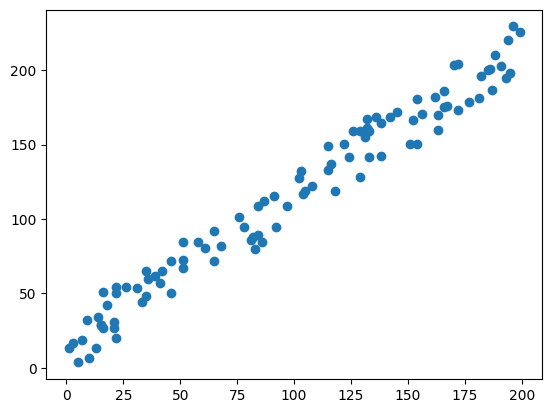

In [122]:
# Визуализируем данные
plt.scatter (data['x'], data['y'])
plt.show()

In [123]:
# Определяем долю тренировочной выборки:
train_ratio = 0.8

# Разбиваем данные на тренировочную и тестовую выборки.
train_size = int(train_ratio * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [124]:
# Обучаем модель
model = LinearRegression().fit(train_data[['x']], train_data['y'])

# Выводим метрику:
metric_value = model.score(test_data[['x']], test_data['y'])
print(f"Model test accuracy is: {metric_value:.3f}")

Model test accuracy is: 0.951


In [125]:
# Сохраняем модель
pickle.dump(model, open('model.pkl', 'wb'))

#### Проверка работы модели с помощью Pytest

Создадим скрипт run_model.py для запуска модели

In [126]:
%%writefile run_model.py
import pickle
import pandas as pd

def model_metric(file_no):
    """Проверяем работу модели"""
    
    # Загружаем модель
    with open('model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    # Определяем путь для файла загружаемого датасета.
    data_file = 'data/data_' + str(file_no) + '.csv'
    
    # Загружаем датасет.
    data = pd.read_csv(data_file)
    
    # Проверяем работу модели
    metric_value = model.score(data[['x']], data['y'])
    return metric_value


Overwriting run_model.py


Создадим скрипт test_run_model.py для тестирования результатов работы модели.

In [127]:
%%writefile test_run_model.py
import pytest
from run_model import model_metric

list = list(range(2, 5))
@pytest.mark.nondestructive
@pytest.mark.parametrize("file_no",list)

def test_model(file_no):
    assert model_metric(file_no) > 0.9


Overwriting test_run_model.py


In [128]:
# Проверим, как работает модель на других датасетах.
!pytest

============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.2.1, pluggy-1.0.0
rootdir: /Users/andrey/Documents/UrFU/20230511_MLOps/lab5
plugins: asyncio-0.21.0, jupyter-pytest-2-1.0.1, anyio-3.6.2
asyncio: mode=strict
collected 3 items                                                              

test_run_model.py ..F                                                    [100%]

=================================== FAILURES ===================================
________________________________ test_model[4] _________________________________

file_no = 4

    @pytest.mark.nondestructive
    @pytest.mark.parametrize("file_no",list)
    
    def test_model(file_no):
>       assert model_metric(file_no) > 0.9
E       assert 0.6265480295237676 > 0.9
E        +  where 0.6265480295237676 = model_metric(4)

test_run_model.py:9: AssertionError
=============================== warnings summary ===============================
test_run_mode

Как видно, на датасетах №№ 2 и 3 модель показала точность выше 0.9, а на датасете # 4 результаты резко ухудшились.
Будем смотреть, в чем причина.

In [129]:
# Загружаем датафрейм из файла.
data = pd.read_csv('data/data_4.csv')

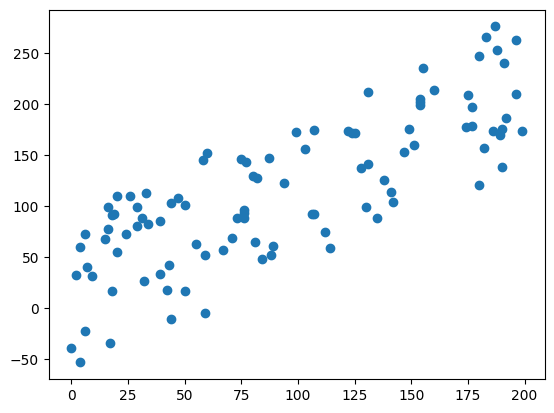

In [130]:
# Визуализируем данные
plt.scatter (data['x'], data['y'])
plt.show()

Понятно, что причина в сильной зашумленности исходных данных датасета № 4.